# 14 Correlation-based feature selection con algoritmos evolutivos

Ana Gil Molina, Levi Malest Villarreal

### Enunciado

Tarea: Feature selection

Dificultad: Media

Coste computacional: Alto

Diseñar un AE como estrategia de búsqueda del método correlation-based feature selection (Tema 5, pág. 11). Implementar el AE con representación binaria, selección por ranking exponencial ($c = 0.3$), muestreo estocástico con reemplazo, sustitución generacional completa, cruce uniforme ($p_c=0.6$), mutación bit-flip ($p_m=0.1$) y $100000$ evaluaciones de la función objetivo. Ejecutar el AE 10 veces con diferente semilla para el conjunto de datos ALL-AML_train. Visualizar gráficamente la evolución del algoritmo (10 runs sobre el mismo gráfico).

### Descripción

<font size="4"> Selección de atributos para clasificación utilizando un algoritmo evolutivo (minimización).
    
### Componentes

- <font size="3"> Método correlation-based feature selection (método filter) y métrica ACC
    
- <font size="3"> Datos:
    
    - Clasificación

    - Entradas numéricas y categóricas 
    
- <font size="3"> Algoritmo evolutivo:
    
    - Representación binaria

    - Selección por ranking exponencial ($c=0.3$)

    - Muestreo estocástico con reemplazamiento

    - Sustitución generacional completa

    - Cruce uniforme ($p_c=0.6$)

    - Mutación bit-flip ($p_m=0.1$)

### Requerimientos

In [45]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

### Lectura de los datos
#### Input:
  - $file\_path\_X$: Nombre completo con path de la base de datos de expresiones génicas
  - $file\_path\_y$: Nombre completo con path de la base de datos con la columna target

  
#### Output:
  - $X$: Atributos de entrada numéricos y categóricos
  - $y$: Salida categórica

In [3]:
file_path_X = './datasets/data_set_ALL_AML_train.csv'

df = pd.read_csv(file_path_X)
df.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


En este dataset, cada fila representa un gen (no un paciente). Las columnas están organizadas de la siguiente manera:

 - `Gene Description`: nombre descriptivo del gen.

 - `Gene Accession Number`: ID del gen.

 - Columnas con números (`1`, `2`, `3`, etc): cada una corresponde a un paciente y contiene la medición de expresión del gen correspondiente para ese paciente.

 - Columnas de tipo `call`, `call.1`, `call.2`, etc: etiqueta correspondiente a cada paciente, asociada a la columna numérica previa.

Por ello, es necesario transponer el dataset para que las filas representen pacientes, y las columnas representen genes.

Por otro lado, las etiquetas del target se encuentran en un dataset separado:

In [4]:
file_path_y = './datasets/actual.csv'

target = pd.read_csv(file_path_y)
target.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [ ]:
# 4. Celdas de verificación de nulos 
df.isnull().values.any()
target.isnull().values.any()

False

In [ ]:
# 4. Celdas de verificación de nulos 
df.isnull().values.any()
target.isnull().values.any()

False

No hay valores nulos en ninguno de los dos datasets.

In [ ]:
# 5. Función LoadData
def LoadData(file_path_X, file_path_y):
    df_X = pd.read_csv(file_path_X)
    df_y = pd.read_csv(file_path_y)
    gene_names = df_X['Gene Accession Number'].values
    
    df_X = df_X.iloc[:, 2::2].T
    df_X.columns = gene_names
    df_X.index = df_X.index.astype(int)
    
    df = df_X.join(df_y, how='inner')
    X = df.drop(columns=['cancer'])
    y = df['cancer']
    
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Precomputar correlaciones 
    corr_matrix = np.abs(X.corr().values)
    target_corrs = np.array([abs(pointbiserialr(y, X[col]).correlation) for col in X.columns])
    
    return X, y, corr_matrix, target_corrs  

In [ ]:
# 6. Carga de datos 
X, y, corr_matrix, target_corrs = LoadData(file_path_X, file_path_y)  

In [10]:
X.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,511,-125,389,-37,793,329,36,191,-37,2
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,837,-36,442,-17,782,295,11,76,-14,3
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,1199,33,168,52,1138,777,41,228,-41,4
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,835,218,174,-110,627,170,-50,126,-91,5
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,649,57,504,-26,250,314,14,56,-25,6


### Parámetros del algoritmo evolutivo

- $G$: Número de generaciones
- $N$: Tamaño de la población
- $p\_c$: Probabilidad de cruce
- $p\_m$: Probabilidad de mutación
- $c=0.3$: Parámetro de la selección por ranking exponencial

In [11]:
G = 200 #1000
N = 50 #100
p_c = 0.6
p_m = 0.1
c = 0.3

### Definición del problema de optimización

$\textit{Maximizar} \ f(\textbf{x}) = \frac{\mathcal{C}(x)\cdot \sigma_D^c(x)}{\sqrt{\mathcal{C}(x)+\mathcal{C}(x)\cdot(\mathcal{C}(x)-1)\cdot\sigma_D^f(x)}}$

- $\textbf{x}=\{x_1,\ldots,x_n\}, x_l\in \{0,1\}$, es el vector de variables de decisión, donde cada componte $x_l=1$ representa que el atributo $x_l$ ha sido seleccionado, siendo $n$ el número de atributos del conjunto de datos.
- $D = (X,y)$: Conjunto de datos.
- $\mathcal{C}(x)$: Cardinalidad del subconjunto de atributos seleccionados (número de variables $x_l$ tales que $x_l=1$).
- $\sigma_D^c(x)$: Correlación promedio entre cada atributo seleccionado en $x$ y el atributo de salida en el conjunto de datos $D$.
- $\sigma_D^f(x)$: Correlación promedio entre cada de los posibles $\binom{C(x)}{2}$ pares de atributos en $x$ en el conjunto de datos $D$.
- El numerador indica la capacidad predictiva (relevancia) del subconjunto de atributos seleccionados, mientras que el denominador indica la redundancia entre esos atributos.

In [ ]:
# 8. Función f 
def f(I, corr_matrix, target_corrs):  
    selected = np.where(I.x == 1)[0]
    k = len(selected)
    if k < 2:
        return 0.0
    
    rcf = np.mean(target_corrs[selected])
    sub_corr = corr_matrix[np.ix_(selected, selected)]
    np.fill_diagonal(sub_corr, np.nan)
    rff = np.nanmean(sub_corr)
    
    return (k * rcf) / np.sqrt(k + k * (k - 1) * rff)

### Definición de individuo

Se define una clase `Individuo` para inicializar los individuos y su fitness correspondiente.

In [13]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n,dtype='int')
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

Mediante la función `InitializePopulation` se inicializa aleatoriamente una población formada por arrays binarios de longitud $n$.

In [14]:
def InitializePopulation(P):
    n = P[0].x.size
    for I in P:    
        I.x[:] = np.random.randint(0,2,n)

### Función de evaluación

La función `evaluate` se usa para evaluar el fitness para un cierto individuo.

In [ ]:
# 11. Función evaluate 
def evaluate(I, corr_matrix, target_corrs):  
    I.f = -f(I, corr_matrix, target_corrs)

### Copia de individuo

In [16]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f 

### Cálculo de las probabilidades acumuladas

La función `calculate_cumulative_probabilities` asigna a cada individuo de la población una probabilidad acumulada a partir de la probabilidad de ser seleccionado.

La selección por ranking exponencial asigna a cada individuo la probabilidad:

$$p_i^t = \frac{c-1}{c^N-1}c^{rank(c_i^t)-1}, i=1,\dots,N$$

donde $c=0.3$ ($c$ cercano a $0$ significa mayor número esperado de descendientes del mejor individuo).

A partir de estas probabilidades, se calcula la probabilidad acumulada de cada cromosoma como:

$$q_i^t = \sum_{j=1}^i p_j^t, i=1,\dots, N $$

In [17]:
def calculate_cumulative_probabilities(cumulative_probabilities, N, c):
    den = c**N - 1
    cumulative_probabilities[0] = (c - 1) / den
    for i in range(1, N):
        cumulative_probabilities[i] = cumulative_probabilities[i-1] + (c - 1) * c**i / den

### Selección por ranking exponencial y muestreo estocástico con reemplazamiento (rueda de ruleta)

La función `selection` se utiliza para implementar un muestreo estocástico con reemplazamiento a partir de las probabilidades acumuladas calculadas con la función `calculate_cumulative_probabilities`. Este esquema de muestreo consiste en:

Repetir $N$ veces los siguientes pasos:

 - Extraer, con reemplazamiento, un número real aleatorio $r\sim \mathcal{U}(0,1)$.
 - Si $r\leq q_1^t$ entonces se muestrea el primer cromosoma de la población (i=1) en la generación $t$, y en otro caso se muestrea el $i$-ésimo cromosoma ($2\leq i\leq N$) tal que $q_{i-1}^t<r\leq q_i^t$.

In [18]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

### Cruce
- Cruce uniforme con probabilidad $p\_c$

In [19]:
def crossover(x1,x2,p_c): 
    if np.random.random()<=p_c:
        for l in range(x1.size):
            if np.random.random()<=0.5:
                x1[l], x2[l] = x2[l], x1[l]     

### Mutación
- Mutación bit-flip con probabilidad $p\_m$

In [20]:
def mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 0 if x[l]==1 else 1

### Progreso del algoritmo

In [21]:
def IniciaProgreso(best_individuo,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(best_individuo,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(best_individuo,gen,best_outputs,progression_bar):
    acc = - best_individuo.f
    num_selected = np.count_nonzero(best_individuo.x == 1)
    progression_bar.set_description("Generation: %s ACC cv: %s Selected: %s " % (str(gen), str(acc), str(num_selected)))
    best_outputs[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

Mediante la función `EA` se implementa el algoritmo evolutivo.

In [ ]:
# 18. Función EA 
from joblib import Parallel, delayed  # NUEVO: import añadido

def EA(G, N, p_c, p_m, X, y, c, random_state):
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    assert p_c >= 0.0 and p_c <= 1.0, "La probablidad de cruce debe estar entre 0 y 1."  
    assert p_m >= 0.0 and p_m <= 1.0, "La probablidad de mutación debe estar entre 0 y 1."

    np.random.seed(random_state)
    n = len(X.T)    
    cumulative_probabilities = np.zeros(N)
    
    # Población inicial
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P)
    
    # Evaluación en paralelo 
    def eval_parallel(I):
        evaluate(I, corr_matrix, target_corrs)  # Usa matrices precomputadas
        return I
    P = Parallel(n_jobs=-1)(delayed(eval_parallel)(I) for I in P)
    
    P.sort()    
    best_individuo = P[0]
    best_outputs, progression_bar = IniciaProgreso(min(P),G)    
    
    for gen in range(1,G+1):
        calculate_cumulative_probabilities(cumulative_probabilities,N,c)
        Q = [Individuo(n) for _ in range(N)]
        
        i = 0
        while i < N:
            copia(Q[i], selection(P,cumulative_probabilities))
            copia(Q[i+1], selection(P,cumulative_probabilities))
            crossover(Q[i].x, Q[i+1].x, p_c)
            mutation(Q[i].x, p_m)
            mutation(Q[i+1].x, p_m)
            i += 2  
        
        # Evaluación en paralelo 
        Q = Parallel(n_jobs=-1)(delayed(eval_parallel)(I) for I in Q[1:])  # El primero ya es el mejor
        copia(Q[0], best_individuo)
        
        P = Q
        P.sort()
        best_individuo = P[0] 
        ActualizaProgreso(P[0], gen, best_outputs, progression_bar)
    
    return best_outputs, best_individuo.f, best_individuo.x

### Ejecuciones del algoritmo

A continuación, se ejecuta el AE 10 veces con diferente semilla para el conjunto de datos ALL-AML_train.

In [ ]:
# Ejecuciones del algoritmo 
n_repeat = 10  
best_outputs = np.full(n_repeat, None, dtype=object)
best_fitness = np.zeros(n_repeat)
best_individuos = []

for i in range(n_repeat):
    best_outputs[i], best_fitness[i], best_individuo = EA(
        G=200, N=50, p_c=p_c, p_m=p_m, X=X, y=y, c=c, random_state=i+1  
    )
    best_individuos.append(best_individuo)

print("Media:", np.mean(best_fitness))
print("Máximo:", np.max(best_fitness))
print("Mínimo:", np.min(best_fitness))
print("Desviación estándar:", np.std(best_fitness))

Generation: 200 ACC cv: 0.5118616811309926 Selected: 3547 : : 201it [11:28,  3.43s/it]
Generation: 200 ACC cv: 0.5118847821891258 Selected: 3511 : : 201it [11:06,  3.32s/it]
Generation: 200 ACC cv: 0.5125651735016054 Selected: 3588 : : 201it [11:10,  3.34s/it]

Media: -0.5121038789405746
Máximo: -0.5118616811309926
Mínimo: -0.5125651735016054
Desviación estándar: 0.00032632082245252585


In [25]:
# Guardar los resultados
os.makedirs('./results', exist_ok=True)
np.save('./results/best_outputs.npy', best_outputs)
np.save('./results/best_individuos.npy', best_individuos)
np.save('./results/best_fitness.npy', best_fitness)

### Visualización de la evolución del algoritmo

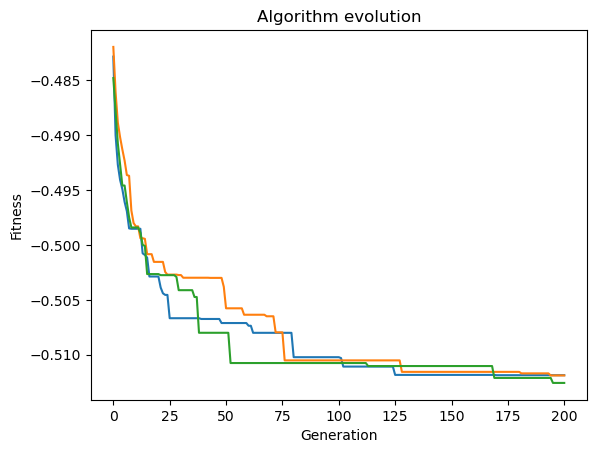

In [26]:
def VisualizaEvolucion(best_outputs, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    for best in best_outputs:
        plt.plot(best)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()
    
VisualizaEvolucion(best_outputs, "Algorithm evolution")

### Visualización de los atributos seleccionados en cada solución

In [27]:
def atributos_seleccionados(individuo):
    print(" Número de atributos seleccionados: ", sum(individuo))
    for i, val in enumerate(individuo):
        if val == 1:
            print(" -> ", X.columns[i])

for i in range(n_repeat):
    print(f"Atributos seleccionados - Run {i+1}:")
    atributos_seleccionados(best_individuos[i])
    print("\n")

Atributos seleccionados - Run 1:
 Número de atributos seleccionados:  3547
 ->  AFFX-BioB-5_at
 ->  AFFX-CreX-3_at
 ->  AFFX-BioC-5_st
 ->  AFFX-BioDn-5_st
 ->  AFFX-CreX-5_st
 ->  AFFX-CreX-3_st
 ->  AFFX-DapX-5_at
 ->  AFFX-DapX-M_at
 ->  AFFX-DapX-3_at
 ->  AFFX-LysX-M_at
 ->  AFFX-PheX-5_at
 ->  AFFX-PheX-M_at
 ->  AFFX-PheX-3_at
 ->  AFFX-ThrX-M_at
 ->  AFFX-ThrX-3_at
 ->  AFFX-TrpnX-5_at
 ->  AFFX-HUMISGF3A/M97935_MA_at
 ->  AFFX-HUMISGF3A/M97935_3_at
 ->  AFFX-HUMRGE/M10098_5_at
 ->  AFFX-HSAC07/X00351_M_at
 ->  AFFX-HUMTFRR/M11507_5_at
 ->  AFFX-HUMTFRR/M11507_M_at
 ->  AFFX-M27830_5_at
 ->  AFFX-M27830_M_at
 ->  AFFX-M27830_3_at
 ->  AFFX-HSAC07/X00351_3_st
 ->  AFFX-HUMGAPDH/M33197_3_st
 ->  AFFX-HSAC07/X00351_M_st
 ->  A28102_at
 ->  AB000114_at
 ->  AB000220_at
 ->  AB000409_at
 ->  AB000450_at
 ->  AB000464_at
 ->  AB000467_at
 ->  AB000896_at
 ->  AB002315_at
 ->  AB002365_at
 ->  AB002366_at
 ->  AB002382_at
 ->  AB002409_at
 ->  AB002559_at
 ->  AB003698_at
 ->  AB00619

### Entrenamiento de los modelos

In [30]:
# Cargar los resultados guardados
#best_outputs = np.load('./results/best_outputs.npy', allow_pickle=True)
#best_individuos = np.load('./results/best_individuos.npy', allow_pickle=True)
#best_fitness = np.load('./results/best_fitness.npy', allow_pickle=True)

try:
    best_outputs = np.load('./results/best_outputs.npy', allow_pickle=True)
    best_individuos = np.load('./results/best_individuos.npy', allow_pickle=True)
    best_fitness = np.load('./results/best_fitness.npy', allow_pickle=True)
except FileNotFoundError:
    print("¡Atención! Primero ejecuta el algoritmo para generar los resultados.")
    best_outputs, best_individuos, best_fitness = [], [], []

In [33]:
print(f"Mejor fitness encontrado: {np.min(best_fitness):.4f}")
print(f"Número de features seleccionados: {np.sum(best_individuos[0])}")

Mejor fitness encontrado: -0.5126
Número de features seleccionados: 3547


In [ ]:

# 1. Cargar datos
X_train, y_train, _, _ = LoadData('./datasets/data_set_ALL_AML_train.csv', './datasets/actual.csv')
X_test, y_test, _, _ = LoadData('./datasets/data_set_ALL_AML_test.csv', './datasets/actual.csv')



# 3. Inicializar modelos
models = {
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "MLP": MLPClassifier(random_state=42)
}

# ==============================================
# TABLA 1: Resultados con selección de características
# ==============================================

results_list = []
for seed in range(10):
    try:
        selected_mask = best_individuos[seed]
        selected_features = X_train.columns[selected_mask == 1]
        X_train_sel = X_train[selected_features]
        X_test_sel = X_test[selected_features]
        
        row_data = {'Seed': seed+1, 'Fitness': best_fitness[seed]}
        
        for model_name, model in models.items():
            model.fit(X_train_sel, y_train)
            row_data[f'ACC ALL-AML_train {model_name}'] = accuracy_score(y_train, model.predict(X_train_sel))
            row_data[f'ACC ALL-AML_test {model_name}'] = accuracy_score(y_test, model.predict(X_test_sel))
        
        results_list.append(row_data)
    except Exception as e:
        print(f"Error en semilla {seed+1}: {str(e)}")
        continue

# Construir y mostrar Tabla 1
if results_list:
    results_table = pd.DataFrame(results_list)
    
    # Calcular estadísticas
    stats_data = {
        'Mejor': results_table.select_dtypes(include=np.number).min(),
        'Peor': results_table.select_dtypes(include=np.number).max(),
        'Promedio': results_table.select_dtypes(include=np.number).mean(),
        'Desviación típica': results_table.select_dtypes(include=np.number).std()
    }
    
    # Tabla final
    final_table = pd.concat([
        results_table,
        pd.DataFrame([stats_data['Mejor']]).assign(Seed='Mejor'),
        pd.DataFrame([stats_data['Peor']]).assign(Seed='Peor'),
        pd.DataFrame([stats_data['Promedio']]).assign(Seed='Promedio'),
        pd.DataFrame([stats_data['Desviación típica']]).assign(Seed='Desviación típica')
    ], ignore_index=True)
    
    # Formatear
    column_order = ['Seed', 'Fitness'] + sorted([c for c in final_table.columns if c not in ['Seed', 'Fitness']])
    final_table = final_table[column_order].round(4)
    final_table.replace(np.nan, '', inplace=True)

    print("="*100)
    print("AE – Correlation-based feature selection - Resultados completos")
    print("="*100)
    display(final_table)
else:
    print("No se generaron resultados válidos para la Tabla 1")

# ==============================================
# TABLA 2: Resultados con TODOS los atributos
# ==============================================

# Evaluar modelos con todos los features
all_features_results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    all_features_results[f'ACC ALL-AML_train {model_name}'] = accuracy_score(y_train, model.predict(X_train))
    all_features_results[f'ACC ALL-AML_test {model_name}'] = accuracy_score(y_test, model.predict(X_test))

# Crear DataFrame para Tabla 2
all_features_table = pd.DataFrame({
    'Metrica': ['Todos los atributos']*6,
    'Tipo': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
    'Modelo': ['RF', 'SVM', 'MLP', 'RF', 'SVM', 'MLP'],
    'ACC': [
        all_features_results['ACC ALL-AML_train RF'],
        all_features_results['ACC ALL-AML_train SVM'],
        all_features_results['ACC ALL-AML_train MLP'],
        all_features_results['ACC ALL-AML_test RF'],
        all_features_results['ACC ALL-AML_test SVM'],
        all_features_results['ACC ALL-AML_test MLP']
    ]
})

# Pivotear para formato de imagen
pivoted_table = all_features_table.pivot(
    index='Metrica', 
    columns=['Tipo', 'Modelo'], 
    values='ACC'
).round(4)

# Mostrar Tabla 2
print("\n" + "="*100)
print("RESULTADOS USANDO TODOS LOS ATRIBUTOS")
print("="*100)
display(pivoted_table)

# ==============================================
# Guardar resultados (opcional)
final_table.to_csv('./results/resultados_seleccion.csv', index=False)
pivoted_table.to_csv('./results/resultados_todos_atributos.csv')

AE – Correlation-based feature selection - Resultados completos


,Seed,Fitness,ACC ALL-AML_test MLP,ACC ALL-AML_test RF,ACC ALL-AML_test SVM,ACC ALL-AML_train MLP,ACC ALL-AML_train RF,ACC ALL-AML_train SVM
0,1,0.1406,0.8788,0.6970,0.5758,0.9737,1.0,0.7632
1,2,0.1533,0.9091,0.6970,0.5758,1.0000,1.0,0.7368
2,3,0.1486,0.8485,0.7576,0.5758,1.0000,1.0,0.8158
3,4,0.1718,0.8182,0.6970,0.5758,1.0000,1.0,0.7368
4,5,0.1473,0.8485,0.7576,0.5758,1.0000,1.0,0.8158
5,6,0.1904,0.8788,0.8182,0.5758,1.0000,1.0,0.8158
6,7,0.1380,0.7576,0.7879,0.5758,0.9737,1.0,0.7895
7,8,0.1525,0.8182,0.7576,0.5758,0.9737,1.0,0.7632
8,9,0.1003,0.8485,0.7576,0.5758,0.9737,1.0,0.7895
9,10,0.1310,0.8485,0.6970,0.5758,1.0000,1.0,0.7895



RESULTADOS USANDO TODOS LOS ATRIBUTOS


Tipo                Train                 Test                
Modelo                 RF     SVM  MLP      RF     SVM     MLP
Metrica                                                       
Todos los atributos   1.0  0.7895  1.0  0.7273  0.5758  0.8182

Tras haber realizado la selección de atributos mediante el algoritmo evolutivo implementado, se han evaluado los conjuntos de atributos seleccionados utilizando tres clasificadores: MLP, Random Forest (RF) y SVM, tanto en los conjuntos train como test del dataset ALL-AML.

En cuanto al comportamiento del algoritmo, el fitness promedio fue de $0.1474$, con una desviación típica de $0.0239$, indicando una variación moderada entre ejecuciones. Sin embargo, el mejor valor de fitness fue $0.1003$, mientras que el peor alcanzó $0.1904$, lo que sugiere que el AE encontró subconjuntos de características significativamente distintos a lo largo de los experimentos.

Ahora, en cuanto al accuracy en el conjunto de test, el mejor resultado con RF fue de $0.8182$, claramente superior al obtenido usando todos los atributos ($0.7273$). Además, el promedio con RF en test fue $0.7424$, mejorando ligeramente respecto al uso de todos los atributos. Por otro lado, MLP también se benefició con una media de $0.8455$ frente a $0.8182$ con todos los atributos. Además, el mejor resultado con MLP fue de $0.9091$, bastante superior al valor obtenido con todos los atributos. No obstante, con SVM no se observó ninguna mejora, manteniéndose un valor constante con todas las semillas.

Por otro lado, en cuanto al accuracy en el conjunto de train, se observa que todos los modelos alcanzaron valores cercanos a $1.0$ en entrenamiento, indicando riesgo de sobreajuste, especialmente en RF y SVM. La reducción de atributos no evitó este comportamiento.

En conclusión, la estrategia de selección de características mediante un AE usando el método de correlation-based feature selection ha demostrado ser eficaz para mejorar el rendimiento de los clasificadores RF y MLP en el conjunto de test, en comparación con el uso de todos los atributos. Si embargo, el coste computacional del AE fue considerablemente alto. De hecho, durante la implementación, nos vimos obligados a reducir tanto el número de generaciones (G) como el tamaño de la población (N), ya que el tiempo de ejecución se nos hizo excesivo con los parámetros especificados en el enunciado, debido a limitaciones con nuestros recursos computacionales disponibles. Esta limitación podría haber afectado negativamente a la capacidad del algoritmo para explorar completamente el espacio de soluciones.

A pesar de esta restricción, se obtuvieron resultados competitivos, lo que nos hace pensar que si se utilizasen los parámetros originales sugeridos (con mayor número de generaciones y población), el rendimiento del algoritmo podría mejorar aún más. En resumen, la selección evolutiva de características representa una técnica poderosa, pero demasiado costosa en términos de tiempo de ejecución, por lo que en contextos en los que no se tengan los recursos computacionales adecuados, podría no ser la opción más práctica ni la más viable.